In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retinabloodvessel/Data/test/mask/11.png
/kaggle/input/retinabloodvessel/Data/test/mask/4.png
/kaggle/input/retinabloodvessel/Data/test/mask/9.png
/kaggle/input/retinabloodvessel/Data/test/mask/14.png
/kaggle/input/retinabloodvessel/Data/test/mask/1.png
/kaggle/input/retinabloodvessel/Data/test/mask/2.png
/kaggle/input/retinabloodvessel/Data/test/mask/10.png
/kaggle/input/retinabloodvessel/Data/test/mask/18.png
/kaggle/input/retinabloodvessel/Data/test/mask/12.png
/kaggle/input/retinabloodvessel/Data/test/mask/7.png
/kaggle/input/retinabloodvessel/Data/test/mask/17.png
/kaggle/input/retinabloodvessel/Data/test/mask/5.png
/kaggle/input/retinabloodvessel/Data/test/mask/3.png
/kaggle/input/retinabloodvessel/Data/test/mask/16.png
/kaggle/input/retinabloodvessel/Data/test/mask/8.png
/kaggle/input/retinabloodvessel/Data/test/mask/6.png
/kaggle/input/retinabloodvessel/Data/test/mask/15.png
/kaggle/input/retinabloodvessel/Data/test/mask/13.png
/kaggle/input/retinabloodvessel/Data/

In [2]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 725.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but y

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence


2024-11-01 18:13:32.199626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730484812.222787      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730484812.229712      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


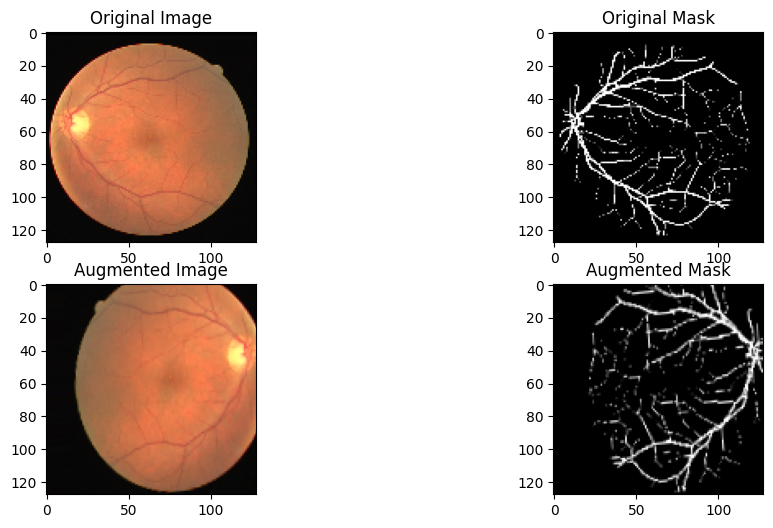

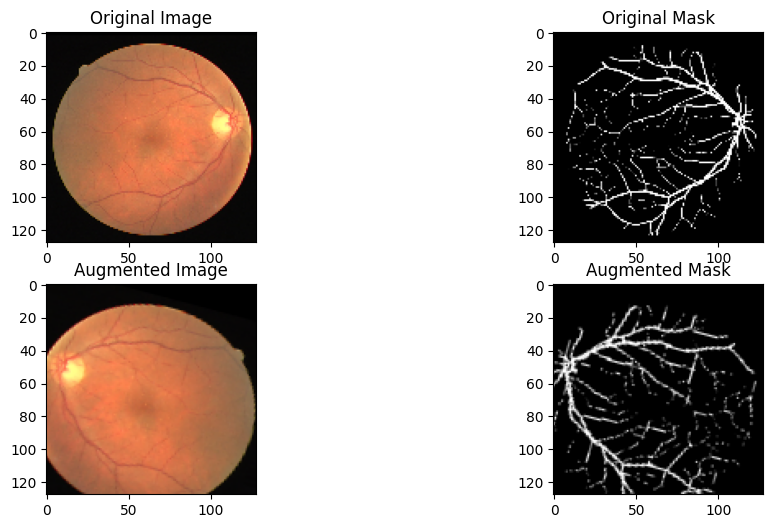

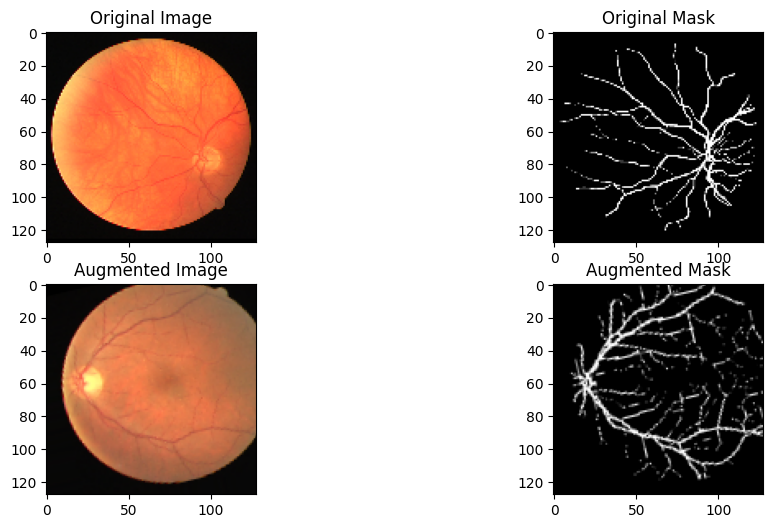

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define paths
image_dir = '/kaggle/input/retinabloodvessel/Data/train/image'
mask_dir = '/kaggle/input/retinabloodvessel/Data/train/mask'

# List images and masks
X_train_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
y_train_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

#Resize images and masks
def load_and_resize(image_path, target_size=(128, 128, 3)):
    img = load_img(image_path, target_size=target_size)
    return img_to_array(img)

#Load 
X_train = np.array([load_and_resize(img) for img in X_train_files])
y_train = np.array([load_and_resize(mask, target_size=(128, 128, 3)) for mask in y_train_files])

# data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Generate augmented
X_augmented = []
y_augmented = []

for i in range(len(X_train)):
    # Reshape images and masks for aug
    img = X_train[i].reshape((1,) + X_train[i].shape)
    mask = y_train[i].reshape((1,) + y_train[i].shape)

    #generate 3 augmented samples/original image
    img_gen = image_datagen.flow(img, batch_size=1, seed=42)
    mask_gen = mask_datagen.flow(mask, batch_size=1, seed=42)

    for _ in range(3):
        X_augmented.append(next(img_gen)[0])  # Use next() to get the augmented image
        y_augmented.append(next(mask_gen)[0])  # Use next() to get the augmented mask

# Convert augmented lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Concatenate original +augmented data
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

#Display
for i in range(3):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(X_train[i].astype(np.uint8))
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(y_train[i].astype(np.uint8))
    plt.title('Original Mask')

    plt.subplot(2, 2, 3)
    plt.imshow(X_train[len(X_train_files) + i].astype(np.uint8))  
    plt.title('Augmented Image')

    plt.subplot(2, 2, 4)
    plt.imshow(y_train[len(y_train_files) + i].astype(np.uint8))  
    plt.title('Augmented Mask')

    plt.show()


In [5]:
# Print shapes and sizes of training images and masks
print("Training images shape:", X_train.shape)
print("Training images size:", X_train.size)

print("Training masks shape:", y_train.shape)
print("Training masks size:", y_train.size)


Training images shape: (320, 128, 128, 3)
Training images size: 15728640
Training masks shape: (320, 128, 128, 3)
Training masks size: 15728640


In [6]:
y_train = y_train.astype('bool')
print(y_train.dtype)


bool


In [7]:
from tensorflow.keras import backend as K


def dice_coef(a, b):
    hi = a
    pred = b
    hi = keras.layers.Flatten()(hi)   #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou




In [8]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization


from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

#input_shape = (128, 128, 3)
#n_labels    = 3

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

    opt = keras.optimizers.Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[ dice_coef, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [9]:
from tensorflow import keras
input_shape = (128,128,3)
n_labels = 3
model = model_build_func(input_shape, n_labels)
model.summary()

2024-11-01 18:13:45.261540: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     73,856 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ pool3[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool4               │ (None, 8, 8, 256) │          0 │ activation_6[0][

 Total params: 4,869,699 (18.58 MB)

 Trainable params: 4,867,635 (18.57 MB)

 Non-trainable params: 2,064 (8.06 KB)

In [10]:
print(X_train.dtype)
print(y_train.dtype)

print(type(X_train))
print(type(y_train))

X_train = X_train.astype('uint8')
y_train = y_train.astype('float64')

print(X_train.dtype)
print(y_train.dtype) 

float32
bool
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
uint8
float64


In [11]:
print(X_train.shape) 
print(y_train.shape) 

(320, 128, 128, 3)
(320, 128, 128, 3)


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Step 2: Define the model and checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/model_checkpoint.weights.h5',  # Save in Kaggle working directory
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

# Step 3: Load weights from the last checkpoint if available
checkpoint_path = '/kaggle/working/model_checkpoint.weights.h5'
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Checkpoint loaded. Resuming training from the last saved epoch.")
else:
    print("No checkpoint found. Starting training from scratch.")

# Step 4: Start training
history = model.fit(
    X_train, y_train, 
    validation_split=0.1, 
    epochs=100, 
    batch_size=16, 
    callbacks=[checkpoint_callback]
)

No checkpoint found. Starting training from scratch.
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.2786 - jaccard_index: 0.1625 - loss: 0.6685
Epoch 1: saving model to /kaggle/working/model_checkpoint.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - dice_coef: 0.2777 - jaccard_index: 0.1619 - loss: 0.6648 - val_dice_coef: 0.2343 - val_jaccard_index: 0.1327 - val_loss: 0.6636
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.2973 - jaccard_index: 0.1750 - loss: 0.4985
Epoch 2: saving model to /kaggle/working/model_checkpoint.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - dice_coef: 0.2982 - jaccard_index: 0.1756 - loss: 0.4982 - val_dice_coef: 0.3410 - val_jaccard_index: 0.2057 - val_loss: 0.5524
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.3162 - jaccard_index: 0.1879 - loss: 0.4884
Epoch 3: saving model to /kaggle/working/model_checkpoint.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - dice_coef: 0.3165 - jaccard_index:

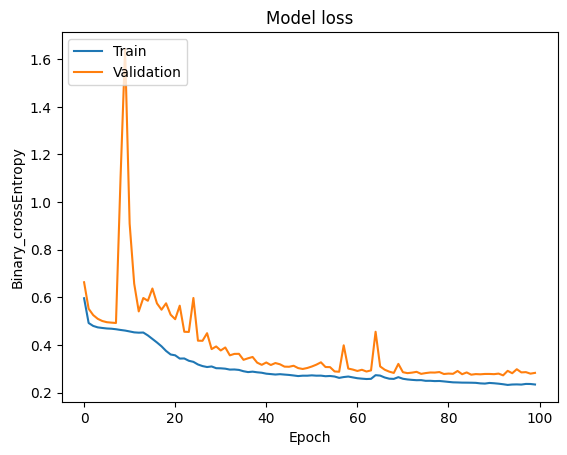

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #g
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy') #
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left') #p
plt.show() #p
#p

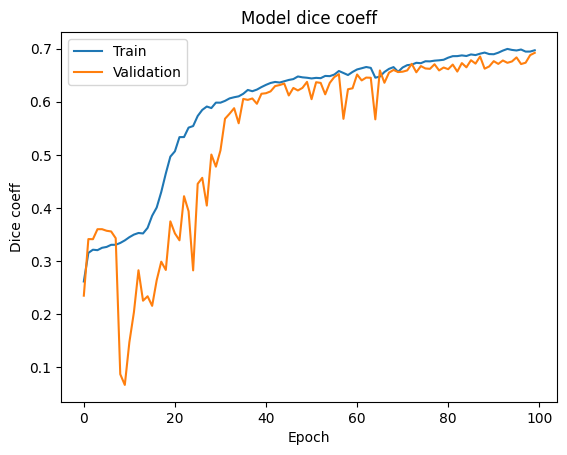

In [23]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef']) #j
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

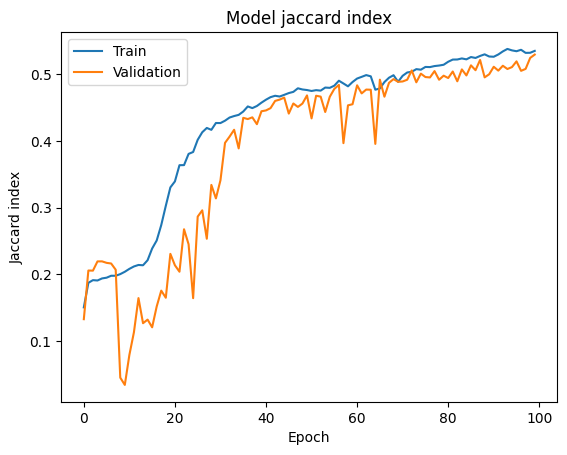

In [24]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths to test images and masks on Kaggle
test_image_dir = '/kaggle/input/retinabloodvessel/Data/test/image'
test_mask_dir = '/kaggle/input/retinabloodvessel/Data/test/mask'

# List test images and masks
X_test_files = sorted([os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)])
y_test_files = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir)])

# Resize images and masks to 128x128 and load them into arrays
def load_and_resize(image_path, target_size=(128, 128, 3)):
    img = load_img(image_path, target_size=target_size)
    return img_to_array(img)

# Load test images and masks with 3D shape
X_test = np.array([load_and_resize(img) for img in X_test_files])
y_test = np.array([load_and_resize(mask, target_size=(128, 128, 3)) for mask in y_test_files])




In [26]:
X_test = X_test.astype('uint8')
y_test = y_test.astype('float64')

In [27]:
test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
(20, 128, 128, 3)
<class 'numpy.ndarray'>


In [28]:
def dice_coef2(a, b):

    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi) # K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [29]:
#dice_list = np.array(len(test_preds))
#jaccard_list = np.array(len(test_preds))
avg_dice = 0
avg_jaccard = 0
for x in range(len(test_preds)):
    i = y_test[x]
    j = test_preds[x]
    avg_dice = avg_dice + tf.get_static_value(dice_coef2(i,j))
    avg_jaccard = avg_jaccard + tf.get_static_value(jaccard_index2(i,j))

print('Average Test Dice co-efficent: ', avg_dice/len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard/len(test_preds))

Average Test Dice co-efficent:  0.6367218255996704
Average Test Jaccrad Index:  0.46783464699983596


In [30]:
print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))
print('Average Test Dice co-efficent: ', avg_dice/len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard/len(test_preds))

Lowest training loss:  0.23272794485092163
Lowest validation loss:  0.27290546894073486
Highest training dice coefficient:  0.699713945388794
Highest validation dice coefficient:  0.692375123500824
Highest training jaccrad index:  0.5381411910057068
Highest validation jaccard index:  0.5296536684036255
Average Test Dice co-efficent:  0.6367218255996704
Average Test Jaccrad Index:  0.46783464699983596
